In [108]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from scipy.stats import skew, kurtosis

np.random.seed(42)
tf.random.set_seed(42)

CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"

df = pd.read_csv(CSV_PATH)
print(f"Dataset contains {len(df)} entries")
print(df.head())

image_data = []
labels = []
valid_indices = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row['image_idx'])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128)) 
            image_data.append(img)
            labels.append(row['blood(mg/dL)'])
            valid_indices.append(idx)

image_data = np.array(image_data)
labels = np.array(labels)
print(f"\nSuccessfully loaded {len(image_data)} images")

Dataset contains 2235 entries
   patient_id   image_idx gender  gestational_age  age(day)  weight  \
0           3  0003-1.jpg      F               40       5.2    3280   
1           3  0003-2.jpg      F               40       5.2    3280   
2           3  0003-3.jpg      F               40       5.2    3280   
3          35  0035-1.jpg      M               39       8.7    3760   
4          35  0035-2.jpg      M               39       8.7    3760   

   blood(mg/dL)  Treatment  
0           3.9          0  
1           3.9          0  
2           3.9          0  
3          12.2          0  
4          12.2          0  

Successfully loaded 2235 images


In [109]:
def white_balance(img):
    avg_b = np.mean(img[:,:,0])
    avg_g = np.mean(img[:,:,1])
    avg_r = np.mean(img[:,:,2])
    
    avg_gray = (avg_b + avg_g + avg_r) / 3
    
    img[:,:,0] = np.minimum(img[:,:,0] * (avg_gray / avg_b), 255)
    img[:,:,1] = np.minimum(img[:,:,1] * (avg_gray / avg_g), 255)
    img[:,:,2] = np.minimum(img[:,:,2] * (avg_gray / avg_r), 255)
    
    return img.astype(np.uint8)

def extract_skin(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower = np.array([0, 30, 60], dtype=np.uint8)
    upper = np.array([20, 150, 255], dtype=np.uint8)
    
    mask = cv2.inRange(hsv, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return cv2.bitwise_and(img, img, mask=mask)

def crop_center(img, fraction=0.4):
    h, w = img.shape[:2]
    ch, cw = int(h * fraction), int(w * fraction)
    start_x, start_y = (w - cw) // 2, (h - ch) // 2
    return img[start_y:start_y+ch, start_x:start_x+cw]

def extract_color_features(skin_img):
    features = {}
    b, g, r = cv2.split(skin_img)
    features['rgb'] = [r, g, b]
    hsv = cv2.cvtColor(skin_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    features['hsv'] = [h, s, v]
    lab = cv2.cvtColor(skin_img, cv2.COLOR_BGR2LAB)
    l, a, b_lab = cv2.split(lab)
    features['lab'] = [l, a, b_lab]
    ycbcr = cv2.cvtColor(skin_img, cv2.COLOR_BGR2YCrCb)
    y, cb, cr = cv2.split(ycbcr)
    features['ycbcr'] = [y, cb, cr]
    return features

def extract_pixel_statistics(channel):
    mask = channel > 0
    if np.sum(mask) == 0:
        return np.zeros(8)  
    pixels = channel[mask]
    return np.array([
        np.mean(pixels),
        np.std(pixels),
        skew(pixels),
        kurtosis(pixels),
        np.median(pixels),
        np.percentile(pixels, 25),
        np.percentile(pixels, 75),
        np.max(pixels) - np.min(pixels)
    ])

def preprocess_images(images):
    all_features = []
    for img in images:
        balanced = white_balance(img)
        skin = crop_center(balanced)
        color_features = extract_color_features(skin)
        channel_stats = []
        for space in ['rgb', 'hsv']:
            for channel in color_features[space]:
                channel_stats.extend(extract_pixel_statistics(channel))
        all_features.append(channel_stats)
    return np.array(all_features)
print("\nPreprocessing images...")
X = preprocess_images(image_data)

y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)  

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_val = X_val.reshape(-1, X_val.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

print("\nFinal data shapes:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Preprocessing images...

Final data shapes:
Train: (1564, 48, 1), (1564,)
Val: (224, 48, 1), (224,)
Test: (447, 48, 1), (447,)


In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation, InputLayer
from tensorflow.keras.regularizers import l2
def build_1dcnn(input_shape):
    model = Sequential([
        InputLayer(input_shape=input_shape), 

        Conv1D(32, kernel_size=3, padding='same', activation='relu'), 
        MaxPooling1D(pool_size=2, padding='same'),                    

        Conv1D(64, kernel_size=3, padding='same', activation='relu'),  
        MaxPooling1D(pool_size=2, padding='same'),                    

        Conv1D(128, kernel_size=3, padding='same', activation='relu'), 
        MaxPooling1D(pool_size=2, padding='same'),                      

        Conv1D(128, kernel_size=3, padding='same', activation='relu'),  
        MaxPooling1D(pool_size=2, padding='same'),                     

        Flatten(),                                                  

        Dense(256, activation='relu'),                                
        Dropout(0.3),                                                 

        Dense(128, activation='relu'),                                
        Dropout(0.5),                                                  

        Dense(1, activation='linear')                                 
    ])
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10_000,
        decay_rate=0.9)
    
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.Huber(delta=1.0),
                 metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_1dcnn(input_shape)
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_122 (Conv1D)         (None, 48, 32)            128       
                                                                 
 max_pooling1d_93 (MaxPooli  (None, 24, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_123 (Conv1D)         (None, 24, 64)            6208      
                                                                 
 max_pooling1d_94 (MaxPooli  (None, 12, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_124 (Conv1D)         (None, 12, 128)           24704     
                                                                 
 max_pooling1d_95 (MaxPooli  (None, 6, 128)          


Training model...
Epoch 1/150
49/49 [==============================] - 1s 11ms/step - loss: 5.3612 - mae: 5.8431 - root_mean_squared_error: 7.2654 - val_loss: 3.8594 - val_mae: 4.3324 - val_root_mean_squared_error: 5.1093 - lr: 9.9949e-04
Epoch 2/150
49/49 [==============================] - 0s 8ms/step - loss: 3.7997 - mae: 4.2760 - root_mean_squared_error: 5.1930 - val_loss: 3.0452 - val_mae: 3.5142 - val_root_mean_squared_error: 4.2582 - lr: 9.9898e-04
Epoch 3/150
49/49 [==============================] - 0s 8ms/step - loss: 3.1308 - mae: 3.6032 - root_mean_squared_error: 4.4303 - val_loss: 2.2513 - val_mae: 2.6967 - val_root_mean_squared_error: 3.4963 - lr: 9.9846e-04
Epoch 4/150
49/49 [==============================] - 0s 8ms/step - loss: 2.6431 - mae: 3.1079 - root_mean_squared_error: 3.9795 - val_loss: 2.0061 - val_mae: 2.4653 - val_root_mean_squared_error: 3.1291 - lr: 9.9795e-04
Epoch 5/150
49/49 [==============================] - 0s 7ms/step - loss: 2.6146 - mae: 3.0751 - root

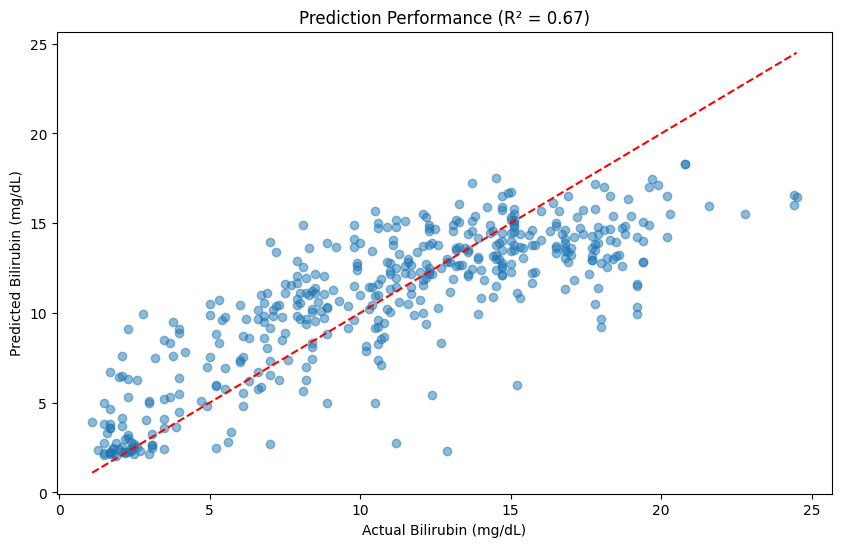

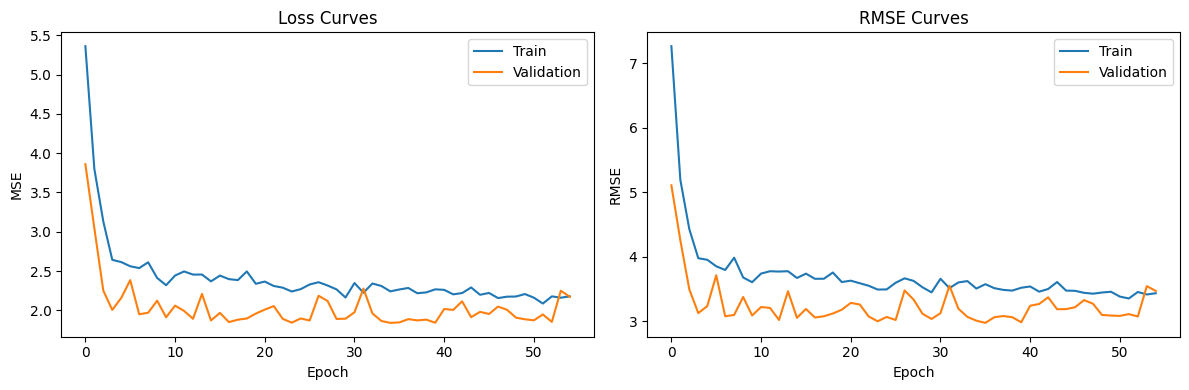

In [111]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)
]

# Train model
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluate  
print("\nEvaluating on test set...")
y_pred = model.predict(X_test).flatten()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.show()

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'], label='Train')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation')
plt.title('RMSE Curves')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/50
40/40 [==============================] - 1s 8ms/step - loss: 0.6997 - accuracy: 0.7122 - val_loss: 0.6781 - val_accuracy: 0.7207
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.5818 - accuracy: 0.7658 - val_loss: 0.6087 - val_accuracy: 0.7281
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.5510 - accuracy: 0.7778 - val_loss: 0.5951 - val_accuracy: 0.7430
Epoch 4/50
40/40 [==============================] - 0s 6ms/step - loss: 0.5219 - accuracy: 0.7818 - val_loss: 0.6830 - val_accuracy: 0.7244
Epoch 5/50
40/40 [==============================] - 0s 6ms/step - loss: 0.5296 - accuracy: 0.7706 - val_loss: 0.5950 - val_accuracy: 0.7449
Epoch 6/50
40/40 [==============================] - 0s 6ms/step - loss: 0.5382 - accuracy: 0.7666 - val_loss: 0.6256 - val_accuracy: 0.7374
Epoch 7/50
40/40 [==============================] - 0s 6ms/step - loss: 0.5096 - accuracy: 0.7818 - val_loss: 0.6023 - val_accuracy: 0.7337
Epoch 8/50
40/40 [==

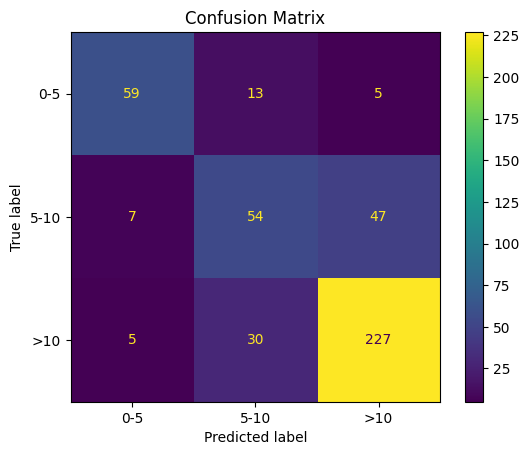

In [112]:
thresholds = [5, 10]  
y_class = np.digitize(labels, thresholds)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

X_train_cls = scaler.transform(X_train_cls)
X_test_cls = scaler.transform(X_test_cls)

X_train_cls = X_train_cls.reshape(-1, X_train_cls.shape[1], 1)
X_test_cls = X_test_cls.reshape(-1, X_test_cls.shape[1], 1)

cls_model = Sequential([
    InputLayer(input_shape=input_shape),
    
    *model.layers[:-5],  
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

cls_model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

cls_history = cls_model.fit(
    X_train_cls, y_train_cls,
    validation_split=0.3,
    epochs=50,
    batch_size=32,
    verbose=1
)

y_pred_cls = np.argmax(cls_model.predict(X_test_cls), axis=1)
accuracy = np.mean(y_pred_cls == y_test_cls)

print(f"\nClassification Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['0-5', '5-10', '>10'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()